In [ ]:
!pip3 install --upgrade yellowbrick

     |████████████████████████████████| 276kB 5.6MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


# 載入常用程式庫及定義

In [ ]:
try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False

if in_colab:
    home_dir = ''
    drive.mount('/content/drive')
    groot_dir = '/content/drive/My Drive/adventures/'
else:
    from pathlib import Path
    home_dir = str(Path.home())
    groot_dir = home_dir + '/Google Drive/adventures/'

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', size=14)

from datetime import datetime
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
import sklearn
assert sklearn.__version__ >= "0.20"
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import sys
import gdown
import requests
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from pandas.plotting import register_matplotlib_converters

data_dir = groot_dir + 'wine quality/'
figure_dir = groot_dir + 'wine quality/'


gfigure = lambda name: figure_dir + name + '.png'
output_fig = lambda name: plt.savefig( gfigure(name), dpi = 300)

local_time = lambda x, offset: x + relativedelta(hours= offset)
def local_now(hours = 8):
    return datetime.now() + relativedelta(hours = hours if in_colab else 0)

def print_now():
    return print(local_now())

def print_local_now():
    return print('Local Time:', local_now())

def fetch_gdrive_file(fid, local_save):
    remote_url = 'https://drive.google.com/uc?id=' + fid
    gdown.download(remote_url, local_save, quiet = False)

def fetch_file_via_requests(url, save_in_dir):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    output_fpath = save_in_dir + local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_fpath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return output_fpath
        
def acct_string(num):
    s0 = str(num)
    if len(s0) <=3:
        return s0  
    num_section = int(len(s0)/3)
    remaining_start = len(s0) % 3
    s = s0[:remaining_start]
    for i in range(num_section):
        s += ',%s' % s0[remaining_start + i*3 :remaining_start + (i+1)*3]   
    return s

TAIWAN_CSV = '1I5yqulrZSHPSQkxT3oqt_3uVAhPolOEP'
RED_WINE = '1ZDg4EfKkkjsWXfs4L3DkZhnAIfnq98Vk'
TITANIC_TRAIN = '1PrxmUKRQWSlYgtMU13l1E0ob4hVJI20O'
JHU_CSSE = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
MNIST_TRAIN = '1E-uJ0zqqAfpsVjoOSzqF5TXhDfPNlkQ5'
MNIST_TRAIN_LABEL = '13clNJ2cd2I90W3DEkDBKjZSDNNEqqx3B'
MNIST_TEST = '1zVpVHJl5YABa3qExt1K-O3WaEHXTJekg'
MNIST_TEST_LABEL = '1qci_-dqubnRN-cdrCsbYaUAxyO7_jH9z'

print('\nThis module is amied to explore wine quality csv...')

print('\nRunning on %s' % sys.platform)
print('Python Version', sys.version)
print('Data storage root points to ==>', groot_dir)
print('Wine Quality data will be stored at ==>', data_dir)
print('\nLibraries and dependenciess imported')
print_local_now()

Mounted at /content/drive

This module is amied to explore wine quality csv...

Running on linux
Python Version 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
Data storage root points to ==> /content/drive/My Drive/adventures/
Wine Quality data will be stored at ==> /content/drive/My Drive/adventures/wine quality/

Libraries and dependenciess imported
Local Time: 2021-04-02 11:15:40.386586


# 熱身：sklearn load_wine

- [sklearn datasets](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets)
- [UCI Archive](https://archive.ics.uci.edu/ml/datasets/Wine)

load_xxxx() 傳回的資料是一種叫 bunch 的資料結構，裏面幾個主要欄位的意義是：

- 'features_names': 特徵名，也就是 X 各欄位的名字
- 'target_names': y 的欄位名稱
- ‘data‘： 資料的內容，也就是 X 的所有數值
- ’target‘：標籤，也就是 y 的數值


In [ ]:
from sklearn.datasets import load_wine

wdata = load_wine()

In [ ]:
for key, value in wdata.items():
    try:
        print(key, value.shape, type(value))
    except:
        print(key, type(value))
print('------')
print(wdata['feature_names'])
print(wdata['target_names'])

data (178, 13) <class 'numpy.ndarray'>
target (178,) <class 'numpy.ndarray'>
target_names (3,) <class 'numpy.ndarray'>
DESCR <class 'str'>
feature_names <class 'list'>
------
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
['class_0' 'class_1' 'class_2']


In [ ]:
wdf = pd.DataFrame(data=wdata['data'], columns=wdata['feature_names'])
wdf['target'] = wdata['target']
wdf

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


### 各欄位的定義

- malic acid 蘋果酸
- ash acid 灰
- alcalinity of ash 灰的鹼性
- magnesium 鎂
- total phenols 總酚
- nonflavanoid_phenols 非類黃酮
- proanthocyanins 原花青素
- color intensity 顏色強度
- hue 色調
- proline 脯氨酸

### 欄位間的關聯

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef91113250>,
      dtype=object)

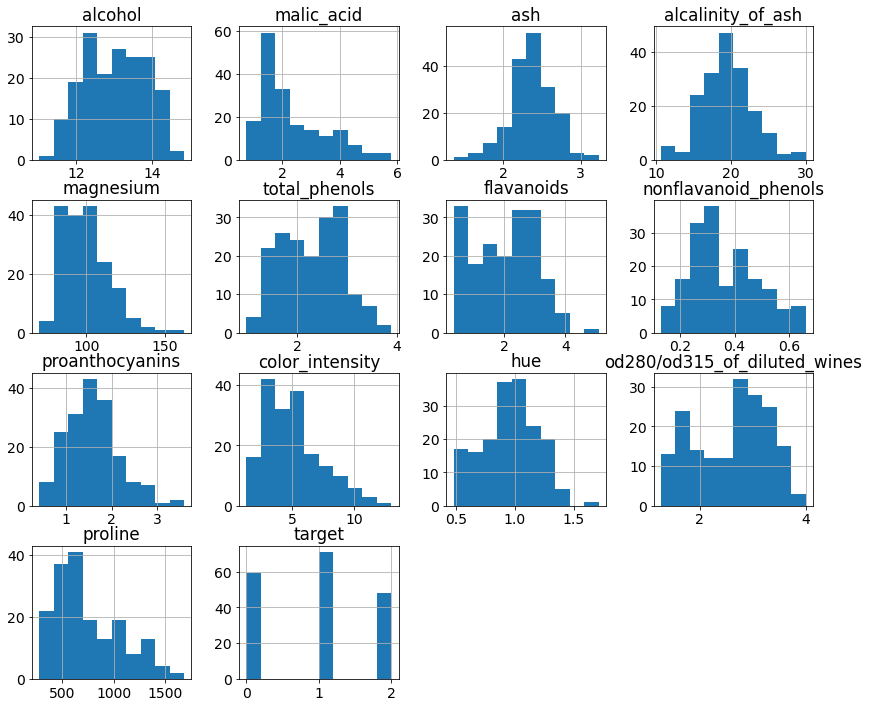

In [ ]:
fig, ax = plt.subplots(figsize=(14, 12))
wdf.hist(ax=ax)

In [ ]:
corr = wdf.corr()
type(corr)

pandas.core.frame.DataFrame

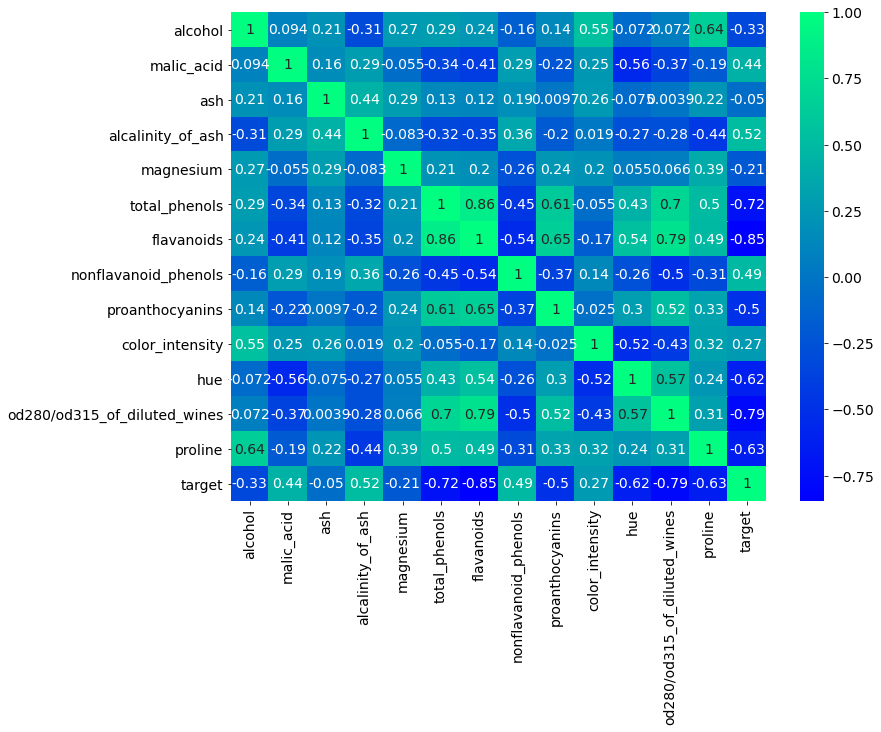

In [ ]:
plt.subplots(figsize=(12, 9))
sns.heatmap(data=corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap='winter')

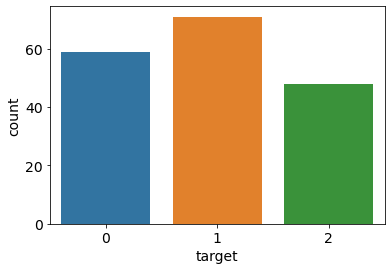

In [ ]:
sns.countplot(x='target', data=wdf)

In [ ]:
##用於categorical 指令 
print(wdf.target.unique(),'\n', wdf.target.value_counts(), '\n', wdf.target.dtype, '\n', wdf['alcalinity_of_ash'].dtype)

[0 1 2] 
 1    71
0    59
2    48
Name: target, dtype: int64 
 int64 
 float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


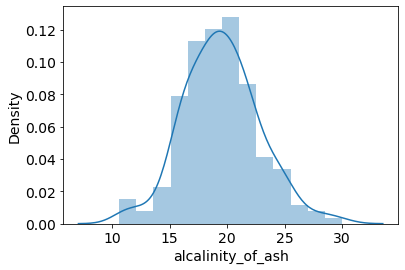

In [ ]:
sns.distplot(wdf.alcalinity_of_ash, kde=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


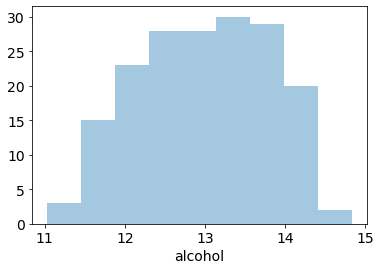

In [ ]:
sns.distplot(wdf.alcohol, kde=0)

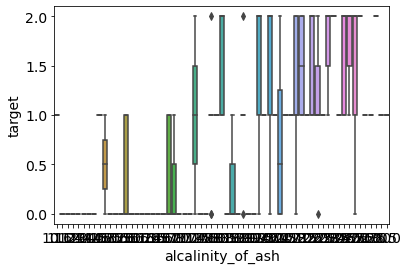

In [ ]:
sns.boxplot(x='alcalinity_of_ash', y='target', data=wdf)

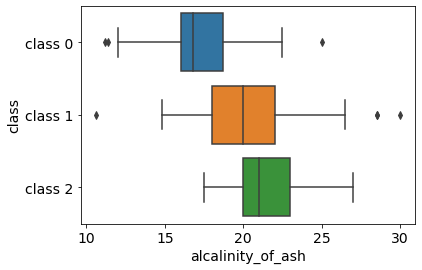

In [ ]:
wdf['class'] = wdf['target'].map({0: 'class 0', 1: 'class 1', 2: 'class 2'})
sns.boxplot(x='alcalinity_of_ash', y='class', data=wdf)

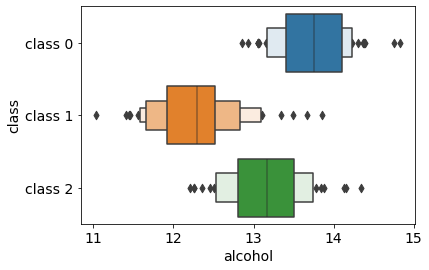

In [ ]:
sns.boxenplot(x='alcohol', y='class', data=wdf)

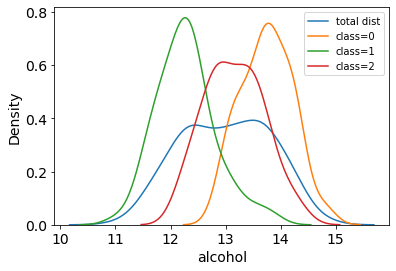

In [ ]:
sns.kdeplot(wdf['alcohol'], label='total dist')
sns.kdeplot(wdf['alcohol'][wdf.target == 0], label='class=0')
sns.kdeplot(wdf['alcohol'][wdf.target == 1], label='class=1')
sns.kdeplot(wdf['alcohol'][wdf.target == 2], label='class=2')
plt.legend(frameon=True)
plt.show()

# 第二個資料檔 Wine Quality

- [UCI: Wine Quality](https://archive.ics.uci.edu/ml/datasets/wine+quality)
- [Predicting Wine Quality with Several Classification Techniques](https://towardsdatascience.com/predicting-wine-quality-with-several-classification-techniques-179038ea6434)
- [Wine Quality CSV (kaggle version)](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009)
- [Step-by-step guide for predicting Wine Preferences using Scikit-Learn](https://medium.com/analytics-vidhya/step-by-step-guide-for-predicting-wine-quality-using-scikit-learn-de5869f8f91a)

## 下載 wine quality data

### from UCI repository

In [ ]:
wine_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

In [ ]:
fetch_file_via_requests(wine_url, data_dir)
wine_dbfile = os.path.join(data_dir, 'winequality-red.csv')

### from shared google drive

In [ ]:
wine_dbfile = os.path.join(data_dir, 'wine.csv')
fetch_gdrive_file(RED_WINE, wine_dbfile)

Downloading...
From: https://drive.google.com/uc?id=1ZDg4EfKkkjsWXfs4L3DkZhnAIfnq98Vk
To: /content/drive/My Drive/adventures/wine quality/wine.csv
100%|██████████| 101k/101k [00:00<00:00, 14.3MB/s]


- [Pandas DataFrame.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

In [ ]:
## Data from UCI 是用 ';' 分隔
## Data from google drive(kaggle) 是用 ',' 分隔
wine_dbfile = os.path.join(data_dir, 'winequality-red.csv')
df = pd.read_csv(wine_dbfile, sep=';')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

- fixed acidity 固定酸度
- volatile acidity 揮發性酸度
- citric acid 檸檬酸
- residual sugar 殘糖
- chlorides 氯化物
- free sulfur dioxide 游離二氧化硫
- total sulfur dioxide 總二氧化硫
- sulphates 硫酸鹽
- alcohol 酒精
- pH 酸鹼值
- density 密度

## Explore Dataset

In [ ]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [ ]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [ ]:
df.shape

(1599, 12)

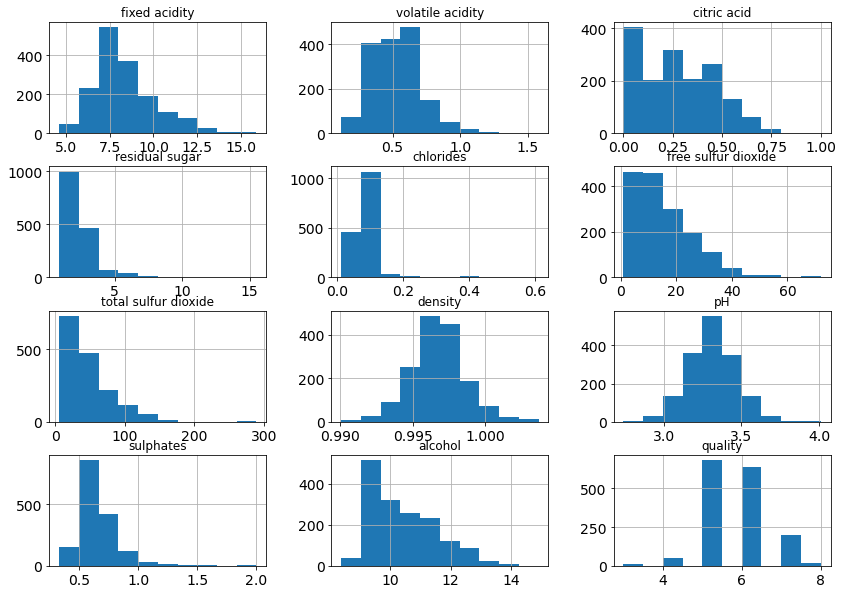

In [ ]:
df.hist(bins=10, figsize=(14, 10))
plt.show()

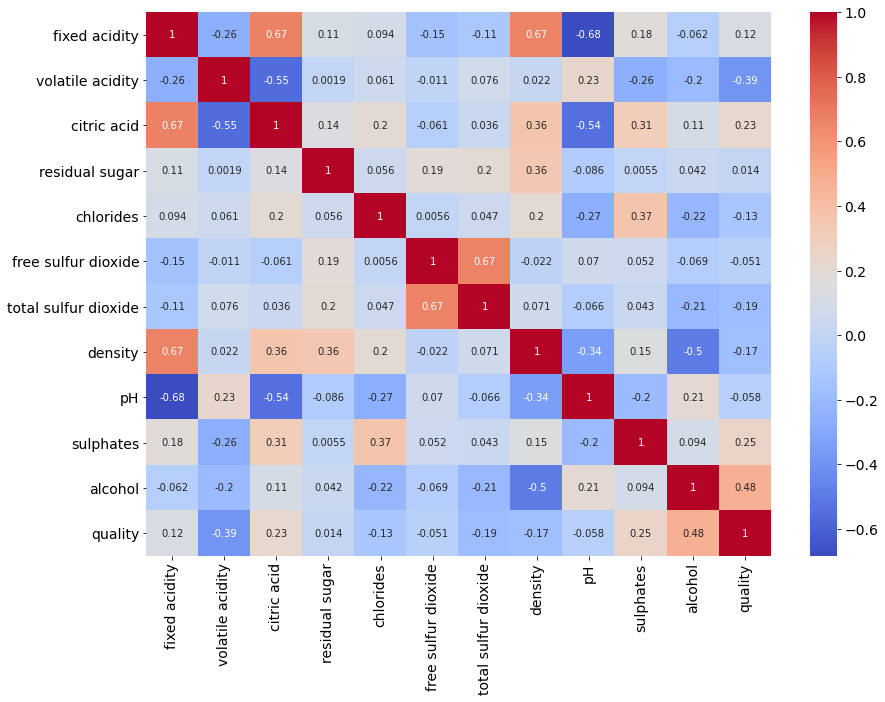

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
corr = df.corr()
sns.heatmap(data=corr, xticklabels=df.columns, yticklabels=df.columns,
            annot=True, cmap='coolwarm', ax=ax)

In [ ]:
df['alcohol'].mean()

10.422983114446502

In [ ]:
df['alcohol'].value_counts()

9.500000     139
9.400000     103
9.800000      78
9.200000      72
10.500000     67
            ... 
11.950000      1
9.233333       1
11.066667      1
13.200000      1
9.566667       1
Name: alcohol, Length: 65, dtype: int64

In [ ]:
len(df['alcohol'].unique())

65

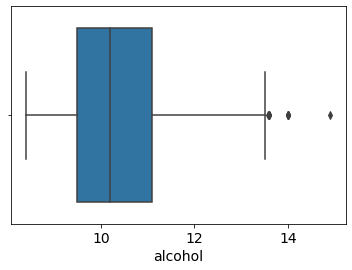

In [ ]:
sns.boxplot(x='alcohol', data=df)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


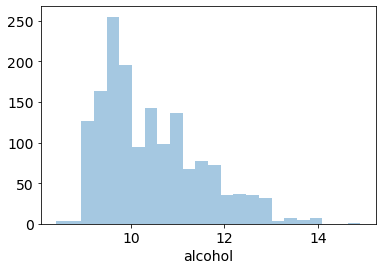

In [ ]:
sns.distplot(df['alcohol'], kde=False)

In [ ]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3])

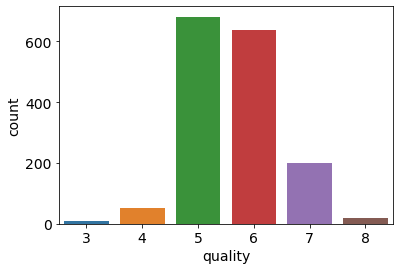

In [ ]:
sns.countplot(x='quality', data=df)

In [ ]:
df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [ ]:
dfqu8 = df.loc[df['quality'] == 8]

In [ ]:
dfqu8.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0
mean,8.566667,0.423333,0.391111,2.577778,0.068444,13.277778,33.444444,0.995212,3.267222,0.767778,12.094444,8.0
std,2.119656,0.144914,0.199526,1.295038,0.011678,11.155613,25.433240,0.002378,0.200640,0.115379,1.224011,0.0
min,5.000000,0.260000,0.030000,1.400000,0.044000,3.000000,12.000000,0.990800,2.880000,0.630000,9.800000,8.0
25%,7.250000,0.335000,0.302500,1.800000,0.062000,6.000000,16.000000,0.994175,3.162500,0.690000,11.325000,8.0
50%,8.250000,0.370000,0.420000,2.100000,0.070500,7.500000,21.500000,0.994940,3.230000,0.740000,12.150000,8.0
75%,10.225000,0.472500,0.530000,2.600000,0.075500,16.500000,43.000000,0.997200,3.350000,0.820000,12.875000,8.0
max,12.600000,0.850000,0.720000,6.400000,0.086000,42.000000,88.000000,0.998800,3.720000,1.100000,14.000000,8.0


### DataFrame Overview 整體資訊

### 特定欄位的相關資訊

### 兩個欄位之間的關係

In [ ]:
corr = df.corr()

In [ ]:
corr.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [ ]:
corr['quality'].sort_values(ascending=False)[1:]

alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

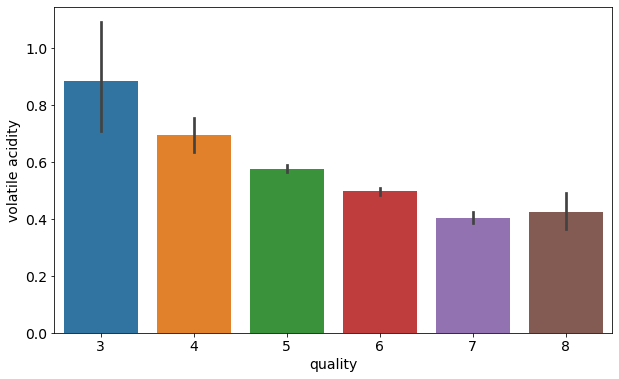

In [ ]:
fig = plt.subplots(figsize=(10, 6))
sns.barplot(x='quality', y='volatile acidity', data=df)

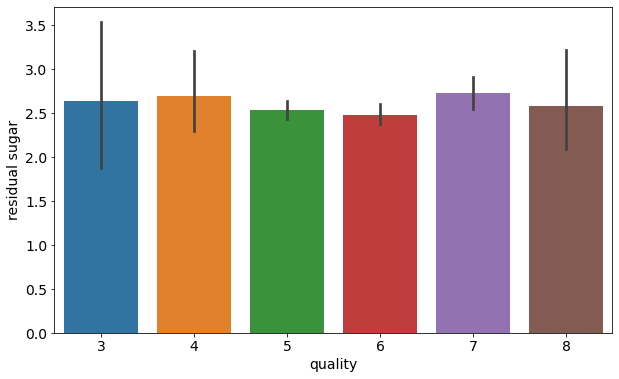

In [ ]:
fig = plt.subplots(figsize=(10, 6))
sns.barplot(x='quality', y='residual sugar', data=df)

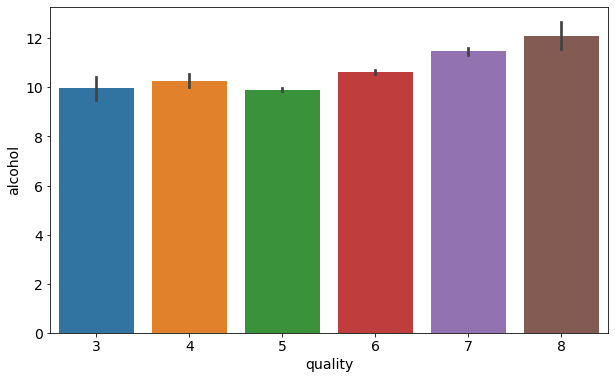

In [ ]:
fig = plt.subplots(figsize=(10, 6))
sns.barplot(x='quality', y='alcohol', data=df)

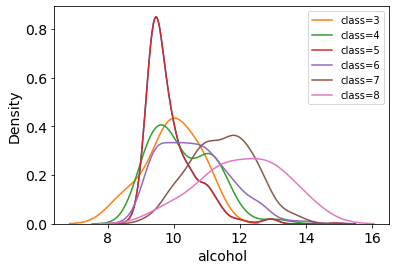

In [ ]:
# sns.kdeplot(df['alcohol'][df['quality']==5])

for i in np.sort(df['quality'].unique()):
    sns.kdeplot(df['alcohol'][df['quality']==i],
                label=f'class={i:d}')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

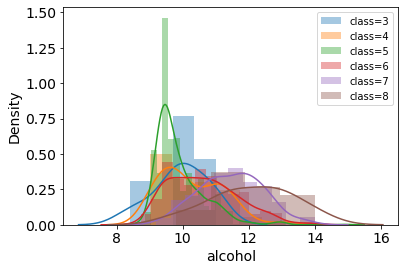

In [ ]:
for i in np.sort(df['quality'].unique()):
    sns.distplot(df['alcohol'][df['quality']==i],
                label=f'class={i:d}')
plt.legend()
plt.show()

## Binay Classification

### Select Classifier

In [ ]:
y6 = df['quality'] > 6
y6

0       False
1       False
2       False
3       False
4       False
        ...  
1594    False
1595    False
1596    False
1597    False
1598    False
Name: quality, Length: 1599, dtype: bool

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


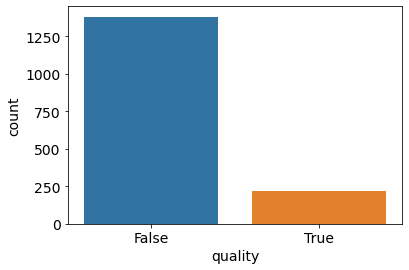

In [ ]:
sns.countplot(y6)

In [ ]:
bins = (2, 6.5, 8)
group_names = ['bad', 'good']
df['quality'] = pd.cut(
    df['quality'], bins=bins, labels = group_names
)

In [ ]:
df['quality']

0       bad
1       bad
2       bad
3       bad
4       bad
       ... 
1594    bad
1595    bad
1596    bad
1597    bad
1598    bad
Name: quality, Length: 1599, dtype: category
Categories (2, object): ['bad' < 'good']

In [ ]:
df['quality'].value_counts()

bad     1382
good     217
Name: quality, dtype: int64

In [ ]:
%%time
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = df.drop(['quality'], axis=1)
y = y6

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# sc = MinMaxScaler()
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

clf = LinearSVC()
clf.fit(x_train, y_train)
y_hat = clf.predict(x_test)
rep = classification_report(y_test, y_hat)
print(rep)
print_now()


              precision    recall  f1-score   support

       False       0.90      0.99      0.94       347
        True       0.81      0.25      0.38        53

    accuracy                           0.89       400
   macro avg       0.85      0.62      0.66       400
weighted avg       0.88      0.89      0.87       400

2021-04-02 11:41:37.412030
CPU times: user 62.1 ms, sys: 0 ns, total: 62.1 ms
Wall time: 63.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


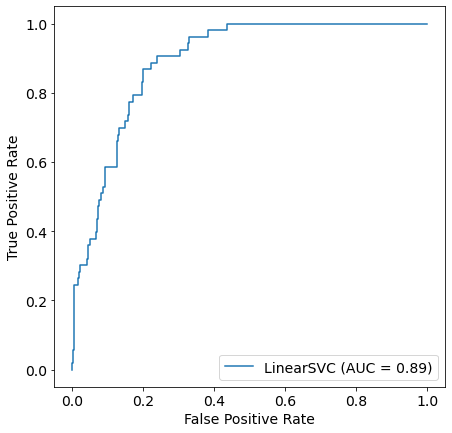

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_roc_curve(clf, x_test, y_test, ax=ax)

## Comparison of Algorithms

- [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
models = []
models.append(('LinearSVC', LinearSVC()))
models.append(('StochasticGD', SGDClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('DecisionTree', DecisionTreeClassifier()))
models.append(('GaussianNB', GaussianNB()))
models.append(('KNeighbors', KNeighborsClassifier()))
# models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('LR Classifier', LogisticRegression()))

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = df.drop(['quality'], axis=1)
y = y6

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

results = []
names = []
scores = []
seed = 7
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f'{name:s} done, {cv_results.mean():f}')

print_now()


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, incr

LinearSVC done, 0.881625
StochasticGD done, 0.840749
RandomForest done, 0.905791
DecisionTree done, 0.879125
GaussianNB done, 0.834846
KNeighbors done, 0.868263


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will ra

LR Classifier done, 0.877451
2021-04-02 12:23:10.093097


In [ ]:
for i, r in enumerate(results):
    print(models[i][0])
    print('mean=%.4f std=%.4f' % (r.mean(), r.std()))

LinearSVC
mean=0.8816 std=0.0340
StochasticGD
mean=0.8407 std=0.0361
RandomForest
mean=0.9058 std=0.0337
DecisionTree
mean=0.8791 std=0.0357
GaussianNB
mean=0.8348 std=0.0191
KNeighbors
mean=0.8683 std=0.0319
LR Classifier
mean=0.8775 std=0.0322


Text(0.5, 1.0, 'Algorithm Comparison')

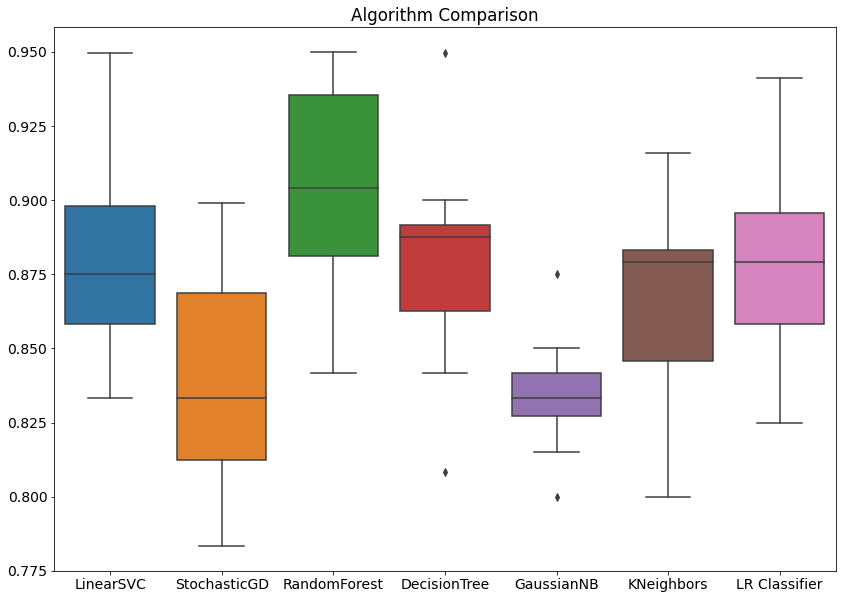

In [ ]:
adf = pd.DataFrame(data=results).transpose()
adf.columns = names
fig, ax = plt.subplots(figsize=(14, 10))
sns.boxplot(data=adf, ax=ax)
plt.title('Algorithm Comparison')

## Tuning Hyperparameters

- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV)
- [kNN API](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier)

In [ ]:
X = df.drop(['quality'], axis=1)
y = y6

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
KNeighborsClassifier().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def knn_param_selection(X, y, nfolds):
    param = {
        'n_neighbors': [1, 3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute']}
    grid_search = GridSearchCV(KNeighborsClassifier(),
            param_grid=param, scoring='accuracy', cv=nfolds)
    
    grid_search.fit(X, y)
    return grid_search.best_params_
print(knn_param_selection(x_train, y_train, 5))
# Return 最好結果

{'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'distance'}


- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html?highlight=linearsvc#sklearn.svm.LinearSVC)